# Exploratory Data Analysis + Handling Missing Data

`TODO`

- Group events per RunID and date
- Examine "impossible" values
- Implement Haversine formula to fill in `speed` = NaN with `Latitude` and `Longitude`
- Tidy script 

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [53]:
# load full data
data = pd.read_csv('processed_data/first_pass.csv')
data

RunID                        Time   Latitude  Longitude  \
0        10018226548  2023-06-26T18:22:43.350000  52.225510   4.504773   
1        10018226548  2023-06-26T18:22:44.350000  52.225522   4.504797   
2        10018226548  2023-06-26T18:22:45.350000  52.225538   4.504827   
3        10018226548  2023-06-26T18:22:46.350000  52.225558   4.504863   
4        10018226548  2023-06-26T18:22:47.350000  52.225573   4.504897   
...              ...                         ...        ...        ...   
1678681   9893577317  2023-06-07T18:42:49.693000  52.224350   4.501980   
1678682   9893577317  2023-06-07T18:42:50.693000  52.224357   4.501937   
1678683   9893577317  2023-06-07T18:42:51.693000  52.224362   4.501897   
1678684   9893577317  2023-06-07T18:42:52.693000  52.224365   4.501860   
1678685   9893577317  2023-06-07T18:42:53.693000  52.224368   4.501827   

         Elevation     Distance  HeartRate  Cadence  Speed  
0           -1.981   283.399994         73     86.0    NaN  
1           -1.829   286.200012         73     87.0    NaN  
2           -1.676   288.500000         73     87.0    NaN  
3           -1.524   290.799988         74     86.0    NaN  
4           -1.372   293.100006         75     86.0    NaN  
...            ...          ...        ...      ...    ...  
1678681      1.067  6122.700195        144     86.0    NaN  
1678682      1.067  6125.799805        144     86.0    NaN  
1678683      0.914  6128.700195        143     85.0    NaN  
1678684      0.914  6131.600098        143     83.0    NaN  
1678685      0.914  6134.399902        143     82.0    NaN  

[1678686 rows x 9 columns]

In [ ]:
# convert to datetime
data['Time'] = pd.to_datetime(data['Time'], errors = 'coerce', utc=True)

# extract the date in YYYY-MM-DD
data['Date'] = data['Time'].dt.date

In [67]:
# aggregate functions
agg_funcs = {
    'Elevation': 'mean',
    'Distance': 'max',
    'HeartRate': 'mean',
    'Cadence': 'mean',
    'Speed': 'mean'}

# aggregate data per run
data_per_run = data[['RunID', 
                     'Date', 
                     'Elevation', 
                     'Distance', 
                     'HeartRate', 
                     'Cadence', 
                     'Speed']].groupby(['RunID', 'Date']).agg(agg_funcs).reset_index()

In [68]:
data_per_run

RunID        Date  Elevation      Distance   HeartRate    Cadence  \
0      741590575  2016-08-10  -0.559788           NaN  155.927865  78.644124   
1      744634852  2016-08-14   6.235153           NaN  149.532697  84.595130   
2      749703915  2016-08-17   8.753312           NaN  136.597015  71.163445   
3      749703916  2016-08-17  -0.974376           NaN  152.375986  75.558772   
4      753631318  2016-08-21   1.483430           NaN  153.641073  84.351686   
..           ...         ...        ...           ...         ...        ...   
501  12249284502  2024-05-22  -2.910637   4483.799805  134.003289  75.805921   
502  12278091080  2024-05-26   0.121194  11042.299805  140.533900  79.648360   
503  12305381020  2024-05-29   2.958158   6090.899902  136.324275  82.432367   
504  12344844634  2024-06-03  -3.972775    364.899994  132.697436  65.215385   
505  12352672778  2024-06-04   2.171392  14054.000000  149.246828  84.081681   

        Speed  
0    3.062487  
1    2.783646  
2    2.484476  
3    3.034197  
4    3.038020  
..        ...  
501       NaN  
502       NaN  
503       NaN  
504       NaN  
505       NaN  

[506 rows x 7 columns]

## Descriptive Analysis: Per run

In [102]:
descriptive_stats = data_per_run.describe()
pd.set_option('display.float_format', '{:.2f}'.format)
descriptive_stats[['Elevation', 'Distance', 'HeartRate', 'Cadence', 'Speed']]

Elevation  Distance  HeartRate  Cadence  Speed
count     504.00    499.00     506.00   496.00  23.00
mean        5.86   9023.78     140.03    78.81   2.60
std        71.48   4725.29      19.17    10.82   0.43
min      -157.46      0.00       0.00    10.56   1.57
25%        -2.56   6058.15     133.81    74.88   2.39
50%         0.74   9272.00     141.15    81.84   2.68
75%         3.75  11739.25     148.51    85.70   2.82
max      1214.28  43286.20     198.74    94.05   3.42

In [69]:
data_per_run.isna().sum()

RunID          0
Date           0
Elevation      2
Distance       7
HeartRate      0
Cadence       10
Speed        483
dtype: int64

In [116]:
data[data["Distance"] == 0]

RunID                             Time  Latitude  Longitude  \
7786     1010000744        2017-03-22 18:15:12+00:00     52.26       4.54   
7787     1010000744        2017-03-22 18:15:13+00:00     52.26       4.54   
23108    1021048125        2017-03-29 17:16:39+00:00     52.26       4.54   
23109    1021048125        2017-03-29 17:16:40+00:00     52.26       4.54   
45062    1032868566        2017-04-05 17:20:36+00:00     52.26       4.54   
...             ...                              ...       ...        ...   
1331476  7350557883 2022-03-30 17:15:39.357000+00:00     52.26       4.54   
1331477  7350557883 2022-03-30 17:15:40.357000+00:00     52.26       4.54   
1331478  7350557883 2022-03-30 17:15:41.357000+00:00     52.26       4.54   
1331479  7350557883 2022-03-30 17:15:42.357000+00:00     52.26       4.54   
1331480  7350557883 2022-03-30 17:15:43.357000+00:00     52.26       4.54   

         Elevation  Distance  HeartRate  Cadence  Speed        Date  
7786          0.91      0.00         78      NaN    NaN  2017-03-22  
7787          0.91      0.00         77     0.00    NaN  2017-03-22  
23108        -2.29      0.00         90     0.00    NaN  2017-03-29  
23109        -2.29      0.00         91     0.00    NaN  2017-03-29  
45062        -1.07      0.00         95     0.00    NaN  2017-04-05  
...            ...       ...        ...      ...    ...         ...  
1331476     -15.54      0.00         72     0.00    NaN  2022-03-30  
1331477     -15.54      0.00         72     0.00    NaN  2022-03-30  
1331478     -15.54      0.00         72     0.00    NaN  2022-03-30  
1331479     -15.54      0.00         72     0.00    NaN  2022-03-30  
1331480     -15.39      0.00         72     0.00    NaN  2022-03-30  

[708 rows x 10 columns]

In [115]:
# two runs with no distance covered whatsoever
data_per_run[data_per_run["Distance"] == 0]

RunID        Date  Elevation  Distance  HeartRate  Cadence  Speed
113  1983036631  2018-09-18      -2.45      0.00     165.33    91.50    NaN
156  2617828766  2019-06-19      -1.86      0.00     133.87    84.55    NaN

In [118]:
data[data["RunID"] == 1983036631]

RunID                      Time  Latitude  Longitude  Elevation  \
505929  1983036631 2018-09-18 17:30:03+00:00     52.23       4.52       0.15   
505930  1983036631 2018-09-18 17:30:04+00:00     52.23       4.52       0.15   
505931  1983036631 2018-09-18 17:30:05+00:00     52.23       4.52       0.15   
505932  1983036631 2018-09-18 17:30:06+00:00     52.23       4.52       0.15   
505933  1983036631 2018-09-18 17:30:07+00:00     52.23       4.52       0.15   
...            ...                       ...       ...        ...        ...   
507691  1983036631 2018-09-18 17:59:25+00:00     52.23       4.52      -2.90   
507692  1983036631 2018-09-18 17:59:26+00:00     52.23       4.52      -2.90   
507693  1983036631 2018-09-18 17:59:27+00:00     52.23       4.52      -2.90   
507694  1983036631 2018-09-18 17:59:28+00:00     52.23       4.52      -2.90   
507695  1983036631 2018-09-18 17:59:29+00:00     52.23       4.52      -2.90   

        Distance  HeartRate  Cadence  Speed        Date  
505929      0.00         71     0.00    NaN  2018-09-18  
505930       NaN         71     0.00    NaN  2018-09-18  
505931       NaN         72     0.00    NaN  2018-09-18  
505932       NaN         72     0.00    NaN  2018-09-18  
505933       NaN         72     0.00    NaN  2018-09-18  
...          ...        ...      ...    ...         ...  
507691       NaN        181    73.00    NaN  2018-09-18  
507692       NaN        180    73.00    NaN  2018-09-18  
507693       NaN        180    65.00    NaN  2018-09-18  
507694       NaN        180    61.00    NaN  2018-09-18  
507695       NaN        179    61.00    NaN  2018-09-18  

[1767 rows x 10 columns]

## Descriptive Analysis: Full

In [103]:
descriptive_stats = data.describe()
pd.set_option('display.float_format', '{:.2f}'.format)
descriptive_stats[['Elevation', 'Distance', 'HeartRate', 'Cadence', 'Speed']]

Elevation   Distance  HeartRate    Cadence    Speed
count 1635325.00 1627379.00 1678686.00 1640012.00 73353.00
mean        5.79    5680.97     141.32      78.48     2.57
std        72.00    4327.72      24.00      23.62     0.87
min      -169.62       0.00       0.00       0.00     0.00
25%        -3.50    2516.30     133.00      85.00     2.50
50%         0.15    4865.30     145.00      87.00     2.80
75%         5.18    8101.90     155.00      89.00     3.00
max      1310.20   43286.20     235.00     124.00     9.50

In [13]:
# Missing values
data.isna().sum()

RunID              0
Time               0
Latitude        9169
Longitude       9169
Elevation      43361
Distance       51307
HeartRate          0
Cadence        38674
Speed        1605333
dtype: int64

In [80]:
print("Distance = 0:", len(data[data['Distance'] == 0]))
print("HeartRate = 0:", len(data[data['HeartRate'] == 0]))
print("Cadence = 0:", len(data[data['HeartRate'] == 0]))

Distance = 0: 708
HeartRate = 0: 1375
Cadence = 0: 1375


In [120]:
# Only one run which recorded heartRate = 0
data[data['HeartRate'] == 0]["RunID"].unique()

array([787870341], dtype=int64)

In [99]:
# Why more than 506 runs???
data[data['Cadence'] == 0]["RunID"].unique()

array([10018226548, 10031900700, 10054537713, 10070835483,  1010000744,
       10124166685,  1015556479,  1015556576, 10177211596, 10193201459,
        1021048125, 10229330223, 10263368911, 10285365305, 10302806496,
        1032868566, 10334097744, 10359191771, 10400951154,  1040824037,
        1046360239, 10470506990,  1054969048, 10598557977,  1061138029,
        1061138074, 10613801755, 10631152061, 10645199130,  1065041814,
       10691756958,  1070743204, 10737330917, 10760176352, 10775215502,
       10781176131,  1083928690, 10845842564, 10880277641,  1088907504,
       10913976196, 10928959206, 10950091216,  1095168309,  1095168312,
        1095168313,  1095168314, 10971569745,  1100274646, 11013508528,
       11050671222, 11069124938, 11089153258,  1111775344, 11119781198,
       11270582226, 11286792143,  1128721789, 11317551275,  1135115407,
        1143732449,  1143732451,  1143732452,  1143732453,  1143732456,
        1143732606, 11437884463, 11461134492,  1146690219, 11484

## Time-series Analysis: Full

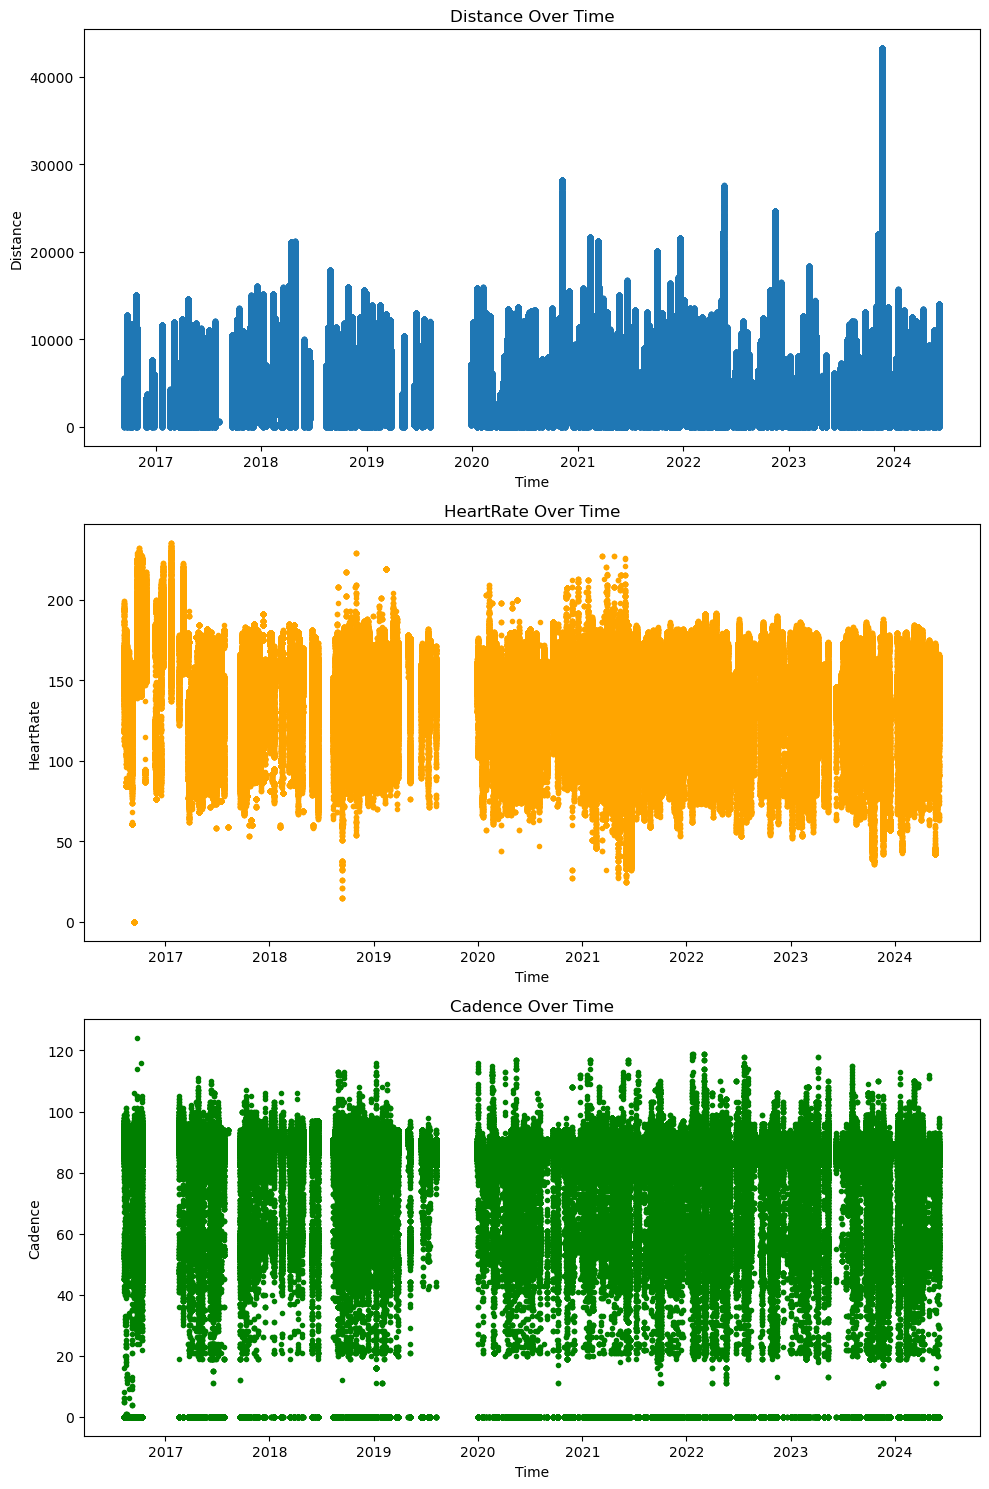

In [71]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# distance over time
ax[0].plot(data['Time'], data['Distance'], '.', label = 'Distance')
ax[0].set_title('Distance Over Time')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Distance')

# heartRate over time
ax[1].plot(data['Time'], data['HeartRate'], '.', label = 'HeartRate', color = 'orange')
ax[1].set_title('HeartRate Over Time')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('HeartRate')

# cadence over time
ax[2].plot(data['Time'], data['Cadence'], '.', label = 'Cadence', color = 'green')
ax[2].set_title('Cadence Over Time')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Cadence')

plt.tight_layout()
plt.show()

## Time-series Analysis: Per run

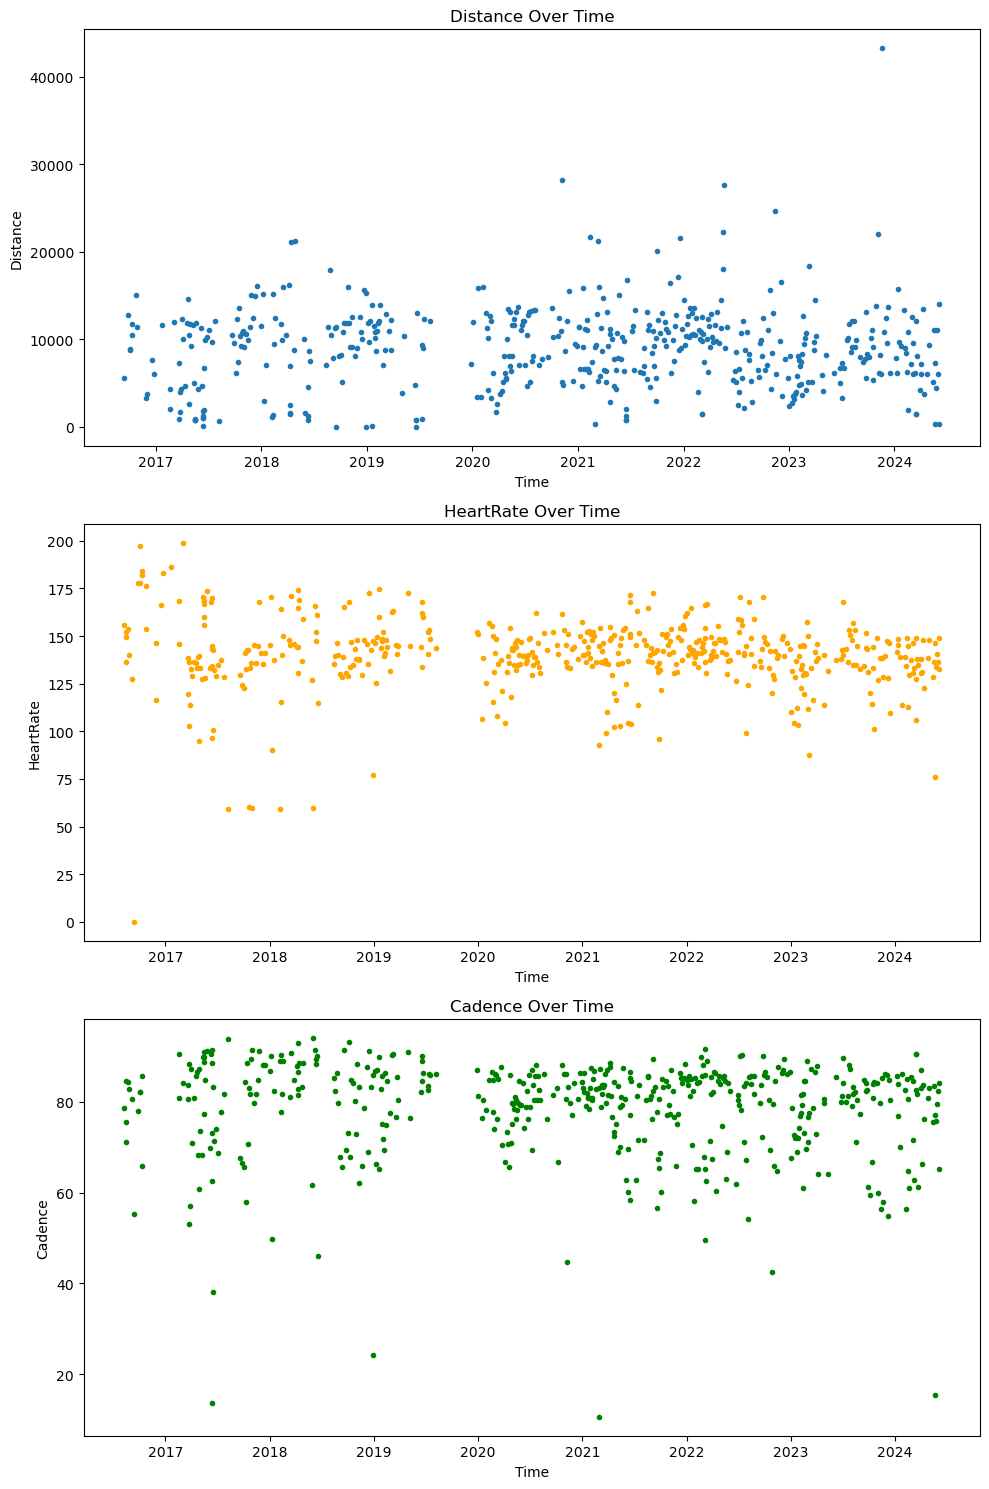

In [72]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# distance over time
ax[0].plot(data_per_run['Date'], data_per_run['Distance'], '.', label = 'Distance')
ax[0].set_title('Distance Over Time')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Distance')

# heartRate over time
ax[1].plot(data_per_run['Date'], data_per_run['HeartRate'], '.', label = 'HeartRate', color = 'orange')
ax[1].set_title('HeartRate Over Time')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('HeartRate')

# cadence over time
ax[2].plot(data_per_run['Date'], data_per_run['Cadence'], '.', label = 'Cadence', color = 'green')
ax[2].set_title('Cadence Over Time')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Cadence')

plt.tight_layout()
plt.show()

In [74]:
# examine average heartrate below 75
data_per_run[data_per_run['HeartRate'] < 75]

RunID        Date  Elevation     Distance  HeartRate    Cadence  \
7     787870341  2016-09-14  -1.844364  5575.000000   0.000000  55.288727   
59   1241530709  2017-08-09   1.463000   623.400024  59.000000  93.866667   
67   1347907211  2017-10-22  -1.338714  9285.900391  60.285714  83.071429   
70   1363595103  2017-11-01   5.943467  9156.000000  60.000000  91.400000   
82   1508216362  2018-02-07  -4.470667  1107.099976  59.333333  89.066667   
100  1730901813  2018-06-01   1.579947  1546.199951  59.578947  94.052632   

        Speed  
7    2.333236  
59        NaN  
67        NaN  
70        NaN  
82        NaN  
100       NaN

In [126]:
data[data['RunID'] == 1241530709]

RunID                      Time  Latitude  Longitude  Elevation  \
333374  1241530709 2017-08-09 18:10:17+00:00     52.26       4.54       1.22   
333375  1241530709 2017-08-09 18:10:18+00:00     52.26       4.54       1.22   
333376  1241530709 2017-08-09 18:10:19+00:00     52.26       4.54       1.22   
333377  1241530709 2017-08-09 18:10:20+00:00     52.26       4.54       2.13   
333378  1241530709 2017-08-09 18:10:21+00:00     52.26       4.54       2.13   
333379  1241530709 2017-08-09 18:10:22+00:00     52.26       4.54       2.13   
333380  1241530709 2017-08-09 18:10:23+00:00     52.26       4.54       2.13   
333381  1241530709 2017-08-09 18:10:24+00:00     52.26       4.54       1.22   
333382  1241530709 2017-08-09 18:10:25+00:00     52.26       4.54       1.22   
333383  1241530709 2017-08-09 18:10:26+00:00     52.26       4.54       1.22   
333384  1241530709 2017-08-09 18:10:27+00:00     52.26       4.54       1.22   
333385  1241530709 2017-08-09 18:10:28+00:00     52.26       4.54       1.22   
333386  1241530709 2017-08-09 18:10:29+00:00     52.26       4.54       1.22   
333387  1241530709 2017-08-09 18:10:30+00:00     52.26       4.54       1.22   
333388  1241530709 2017-08-09 18:10:31+00:00     52.26       4.54       1.22   

        Distance  HeartRate  Cadence  Speed        Date  
333374    569.30         59    94.00    NaN  2017-08-09  
333375    573.00         59    94.00    NaN  2017-08-09  
333376    576.90         59    93.00    NaN  2017-08-09  
333377    580.70         59    94.00    NaN  2017-08-09  
333378    584.40         59    94.00    NaN  2017-08-09  
333379    588.20         59    94.00    NaN  2017-08-09  
333380    592.00         59    94.00    NaN  2017-08-09  
333381    595.80         59    94.00    NaN  2017-08-09  
333382    599.70         59    94.00    NaN  2017-08-09  
333383    603.60         59    94.00    NaN  2017-08-09  
333384    607.60         59    94.00    NaN  2017-08-09  
333385    611.50         59    94.00    NaN  2017-08-09  
333386    615.50         59    94.00    NaN  2017-08-09  
333387    619.40         59    94.00    NaN  2017-08-09  
333388    623.40         59    93.00    NaN  2017-08-09

## Frequency Analysis: Full

C:\Users\Jason\AppData\Local\Temp\ipykernel_4932\3613998802.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['YearMonth'] = data['Time'].dt.to_period('M')


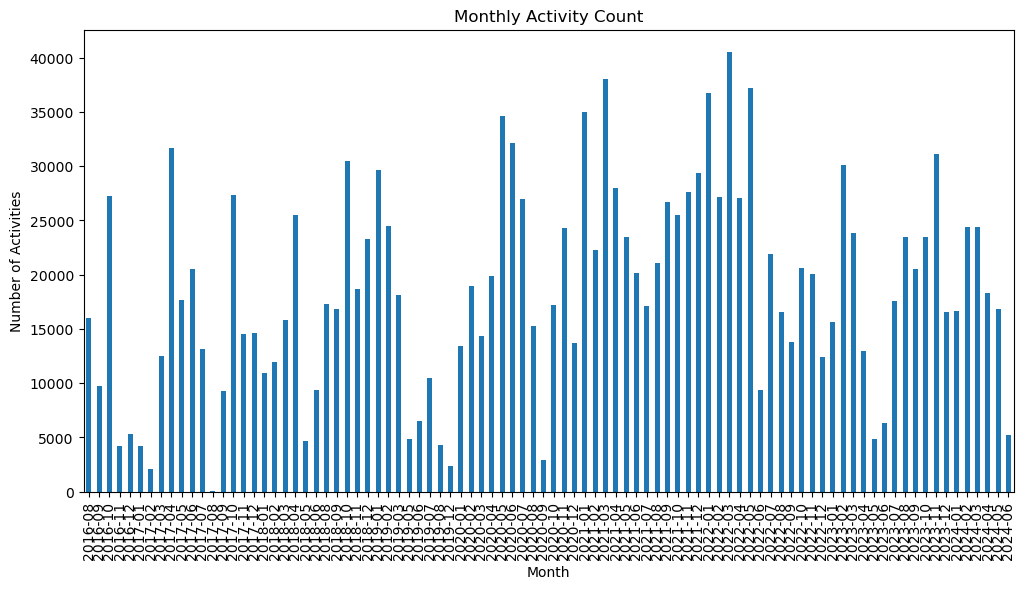

In [25]:
# extract the date part for categorical analysis
data['Date'] = data['Time'].dt.date

# extract year and month for grouping
data['YearMonth'] = data['Time'].dt.to_period('M')

# extract the day of the week for grouping
data['Weekday'] = data['Time'].dt.day_name()

# group by year and month and count activities
monthly_activity_count = data.groupby('YearMonth').size()

# group by weekday and count activities
weekday_activity_count = data.groupby('Weekday').size()

# plot monthly activity count
plt.figure(figsize=(12, 6))
monthly_activity_count.plot(kind='bar')
plt.title('Monthly Activity Count')
plt.xlabel('Month')
plt.ylabel('Number of Activities')
plt.show()

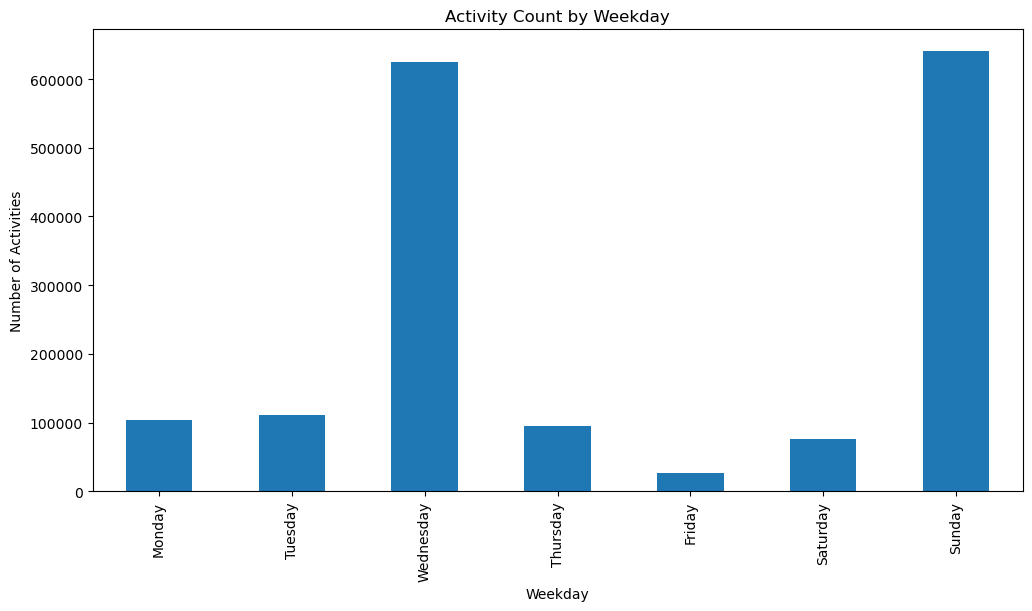

In [26]:
# to ensure the order is Monday to Sunday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_activity_count = weekday_activity_count.reindex(weekday_order)

# plot weekday activity count
plt.figure(figsize=(12, 6))
weekday_activity_count.plot(kind='bar')
plt.title('Activity Count by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Activities')
plt.show()

## Correlation Heatmap

TODO: Perform Haversine formula on NaN values in column `speed` to limit dropped rows.

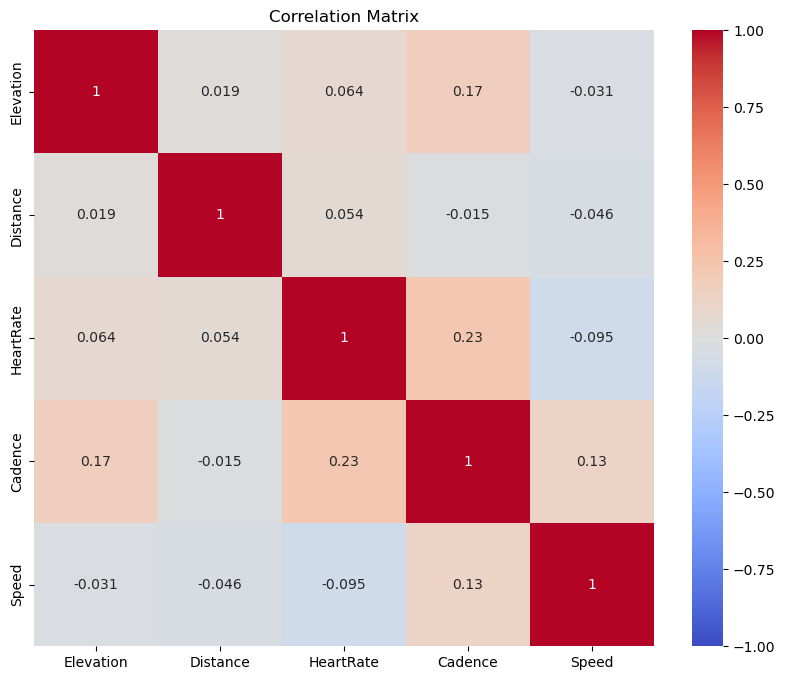

In [16]:
# drop rows with NaN values for correlation analysis
corr_data = data[['Elevation', 'Distance', 'HeartRate', 'Cadence', 'Speed']].dropna()
correlation_matrix = corr_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## Checking outliers

Outliers defined by Z-score > 3

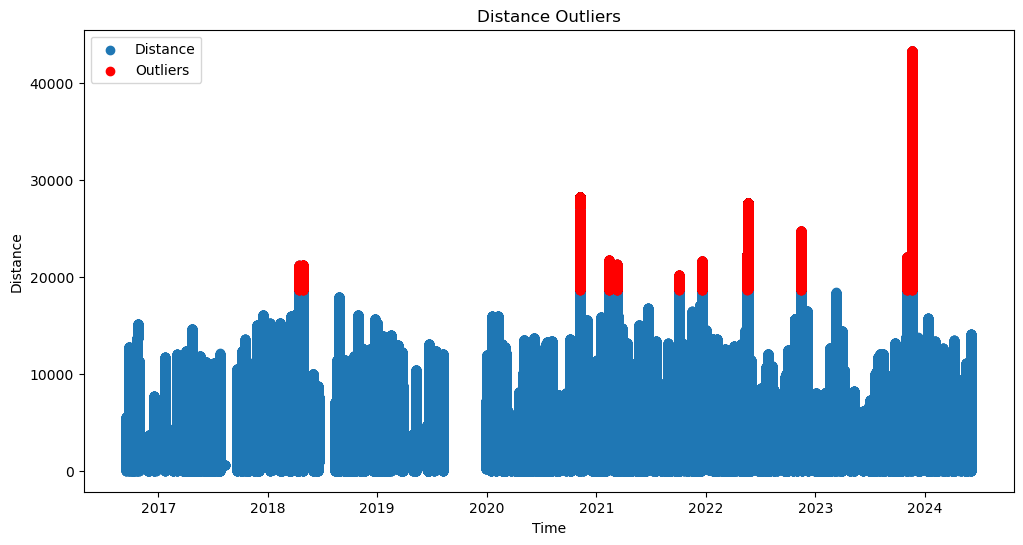

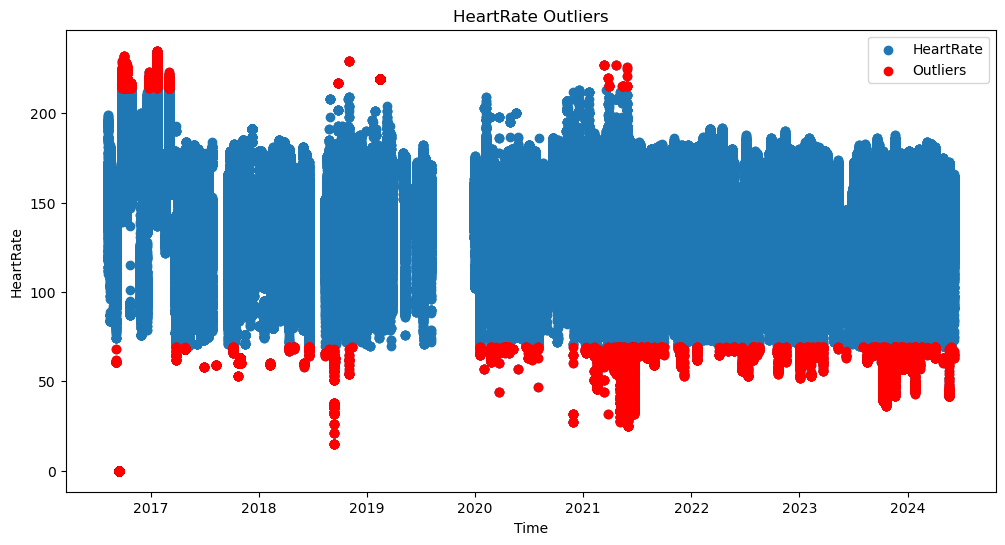

In [17]:
import numpy as np

# identify outliers in 'Distance'
distance_outliers = data[np.abs(data['Distance'] - data['Distance'].mean()) > (3 * data['Distance'].std())]

# identify outliers in 'HeartRate'
heartrate_outliers = data[np.abs(data['HeartRate'] - data['HeartRate'].mean()) > (3 * data['HeartRate'].std())]

# plot distance outliers
plt.figure(figsize=(12, 6))
plt.scatter(data['Time'], data['Distance'], label='Distance')
plt.scatter(distance_outliers['Time'], distance_outliers['Distance'], color='red', label='Outliers')
plt.title('Distance Outliers')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show()

# plot HeartRate outliers
plt.figure(figsize=(12, 6))
plt.scatter(data['Time'], data['HeartRate'], label='HeartRate')
plt.scatter(heartrate_outliers['Time'], heartrate_outliers['HeartRate'], color='red', label='Outliers')
plt.title('HeartRate Outliers')
plt.xlabel('Time')
plt.ylabel('HeartRate')
plt.legend()
plt.show()

In [ ]:
distance_outliers['Distance'].unique()

In [ ]:
heartrate_outliers['HeartRate'].unique()

## K-means Clustering

C:\Users\Jason\anaconda3\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Jason\anaconda3\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Jason\anaconda3\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Jason\anaconda3\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Jason\a

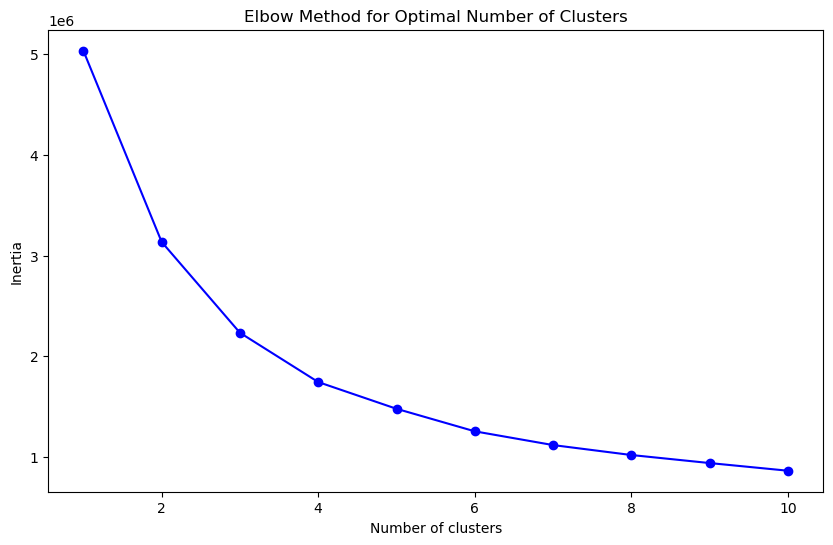

C:\Users\Jason\anaconda3\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


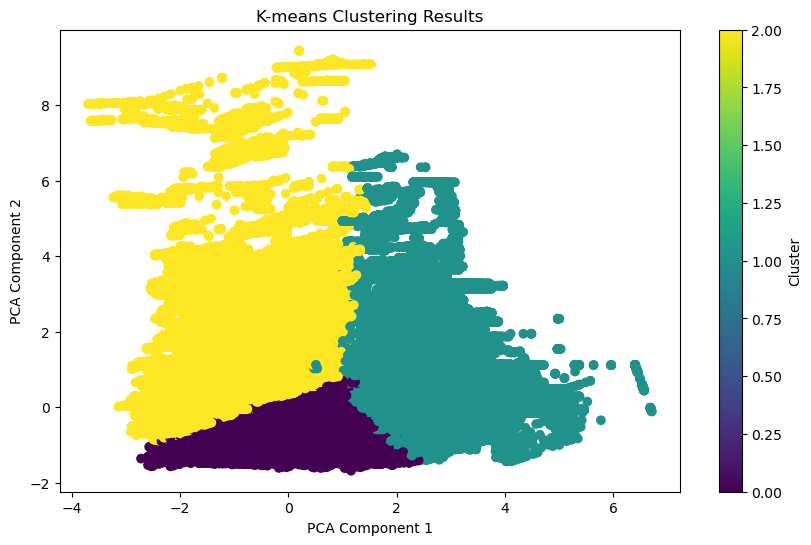

In [34]:
# select features for clustering
features = data[['Distance', 'HeartRate', 'Cadence']]

# filling missing values with the mean of the column
features = features.fillna(features.mean())

# standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# determine the optimal number of clusters (elbow method)
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# choose the optimal clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)

# visualize clusters using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=data['Cluster'], cmap='viridis', marker='o')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering')
plt.colorbar(label='Cluster')
plt.show()